In [1]:
import math

from matplotlib import pyplot as plt

import numpy as np

import torch

import pyro
import pyro.distributions as dist

from util import initialize_model

Here's our toy model. The prior and the likelihood are normal, so the posterior is too.

In [2]:
def model(data):
    loc = pyro.sample("loc", dist.Normal(0,1))
    return pyro.sample("out", dist.Normal(loc, 1), obs=data)

The log prior likelihood is:
$$
\log p(\mu) = -(\mu^2 + \log\sqrt{2\pi})
$$
For a single observation of $x$ of 'out', the log likelihood is:
$$
\log p(x \mid \mu) = -((x-\mu)^2 + \log\sqrt{2\pi})
$$

Let's suppose we have a dataset of size `data_size` $=|\mathcal D|$, and we draw a sample/minibatch of size `data_sample_size` $=|\widetilde{\mathcal D}|$. Let's suppose for each datapoint the value of 'out' is 1.0.

In [3]:
data_size = 100
data_sample_size = 10
data_sample = torch.ones(data_sample_size)

The minibatch potential function is then:
$$
\widetilde U = (|\mathcal D| + 1)\mu^2 - 2 |\mathcal D| \mu + (|\mathcal D|+1)\log\sqrt{2\pi} + |\mathcal D|
$$

Let's compute the minibatch potential function using `initialize_model` and compare it to this analytically derived form. Let's also compare it to the function computed without scaling.

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),)
OrderedDict([('_INPUT',
              {'args': (tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),),
               'kwargs': {},
               'name': '_INPUT',
               'type': 'args'}),
             ('loc',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Normal(loc: 0.0, scale: 1.0),
               'infer': {'_dim_to_id': {}},
               'is_observed': True,
               'kwargs': {},
               'mask': None,
               'name': 'loc',
               'scale': 1.0,
               'stop': False,
               'type': 'sample',
               'value': tensor(-1.1547, requires_grad=True)}),
             ('out',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Normal(loc: -1.1547117233276367, scale: 1.0),
      

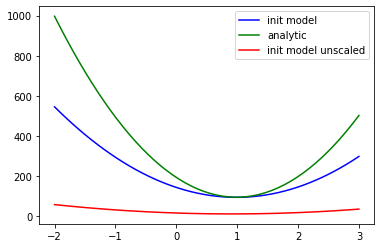

In [4]:
# Compute the minibatch potential function
scale_likelihood = data_size / data_sample_size
_, potential_fn_minibatch, _, _ = initialize_model(
    model,
    model_args=(data_sample,),
    scale_likelihood=scale_likelihood
)

# Compute the minibatch potential function without scaling
_, potential_fn_unscaled, _, _  = initialize_model(
    model,
    model_args=(data_sample,),
    scale_likelihood=1
)

# The analytical potential function
log_sqrt_2pi = math.log(math.sqrt(2 * math.pi))
def potential_fn_minibatch_analytic(loc):
    return ((data_size + 1) * loc * loc
            - 2 * data_size * loc
            + (data_size + 1) * log_sqrt_2pi
            + data_size)

# Plot the different functions
num_samples=50
x = np.linspace(-2, 3, num=num_samples)
y_minibatch = np.empty(num_samples)
y_unscaled = np.empty(num_samples)
y_minibatch_analytic = potential_fn_minibatch_analytic(x)
with torch.no_grad():
    for i in range(num_samples):
        params = {"loc": torch.from_numpy(x[[i]])}
        y_minibatch[i] = potential_fn_minibatch(params)
        y_unscaled[i] = potential_fn_unscaled(params)
fig, ax = plt.subplots(1, 1)
ax.plot(x, y_minibatch, "b", label="init model")
ax.plot(x, y_minibatch_analytic, "g", label="analytic")
ax.plot(x, y_unscaled, "r", label="init model unscaled")
ax.legend()
plt.show()